In [1]:
from fastai.vision.all import *

In [2]:
import os; os.environ['CUDA_VISIBLE_DEVICES']='0,1'

In [3]:
path = Path('/home/user/images')

In [4]:
path.ls()

(#1000) [Path('/home/user/images/Bathygobius krefftii'),Path('/home/user/images/Oncorhynchus gorbuscha'),Path('/home/user/images/Chromis margaritifer'),Path('/home/user/images/Istigobius hoesei'),Path('/home/user/images/Abudefduf sordidus'),Path('/home/user/images/Acanthurus leucopareius'),Path('/home/user/images/Sphoeroides spengleri'),Path('/home/user/images/Orthopristis chrysoptera'),Path('/home/user/images/Etheostoma zonale'),Path('/home/user/images/Morone mississippiensis')...]

In [5]:
df_path = Path('/home/user/')

In [6]:
df = pd.read_csv(df_path/'csv/species1000-stratified.csv')

In [7]:
df

,Order,Family,Subfamily,Genus,Specie,fname,is_valid
0,Perciformes,Centrarchidae,NaN,Lepomis,Lepomis gibbosus,Lepomis gibbosus/1879321.jpg,False
1,Perciformes,Centrarchidae,NaN,Pomoxis,Pomoxis nigromaculatus,Pomoxis nigromaculatus/61056925.jpg,False
2,Perciformes,Centrarchidae,NaN,Lepomis,Lepomis miniatus,Lepomis miniatus/36578909.jpg,False
3,Cypriniformes,Cyprinidae,Leuciscinae,Scardinius,Scardinius erythrophthalmus,Scardinius erythrophthalmus/77068790.jpg,False
4,Perciformes,Acanthuridae,Acanthurinae,Acanthurus,Acanthurus olivaceus,Acanthurus olivaceus/14646458.jpg,False
...,...,...,...,...,...,...,...
422172,Perciformes,Acanthuridae,Acanthurinae,Acanthurus,Acanthurus coeruleus,Acanthurus coeruleus/33472582.jpg,True
422173,Perciformes,Gobiidae,Gobiinae,Amblyeleotris,Amblyeleotris steinitzi,Amblyeleotris steinitzi/3789141.jpg,True
422174,Perciformes,Percidae,Etheostomatinae,Etheostoma,Etheostoma caeruleum,Etheostoma caeruleum/40879890.jpg,True
422175,Perciformes,Kyphosidae,Microcanthinae,Tilodon,Tilodon sexfasciatus,Tilodon sexfasciatus/26825770.jpg,True


In [8]:
weights_df = pd.read_csv(df_path/'csv/species1000-weights.csv')
weights_family_df = pd.read_csv(df_path/'csv/species1000-weights-family.csv')
weights_genus_df = pd.read_csv(df_path/'csv/species1000-weights-genus.csv')
weights_order_df = pd.read_csv(df_path/'csv/species1000-weights-order.csv')

In [9]:
weights_df

,Specie,Count,Weight
0,Abramis brama,319,1.323439
1,Abudefduf abdominalis,221,1.910303
2,Abudefduf bengalensis,323,1.307050
3,Abudefduf saxatilis,1692,0.249514
4,Abudefduf septemfasciatus,149,2.833403
...,...,...,...
995,Zanclus cornutus,1966,0.214739
996,Zebrasoma desjardinii,166,2.543235
997,Zebrasoma flavescens,561,0.752544
998,Zebrasoma scopas,276,1.529627


# Non-branch

In [10]:
fishes = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=ColSplitter(),
                 get_x = ColReader(5, pref=path),
                 get_y=ColReader(4),
                 item_tfms=RandomResizedCrop(336, min_scale=0.5),
                 batch_tfms=aug_transforms())
dls = fishes.dataloaders(df, bs=64)

In [11]:
dls.train_ds, dls.valid_ds

((#337741) [(PILImage mode=RGB size=768x1024, TensorCategory(531)),(PILImage mode=RGB size=1024x738, TensorCategory(776)),(PILImage mode=RGB size=768x1024, TensorCategory(538)),(PILImage mode=RGB size=768x1024, TensorCategory(837)),(PILImage mode=RGB size=1024x786, TensorCategory(32)),(PILImage mode=RGB size=1024x683, TensorCategory(145)),(PILImage mode=RGB size=768x1024, TensorCategory(827)),(PILImage mode=RGB size=1024x697, TensorCategory(792)),(PILImage mode=RGB size=1024x768, TensorCategory(784)),(PILImage mode=RGB size=1024x768, TensorCategory(522))...],
 (#84436) [(PILImage mode=RGB size=576x1024, TensorCategory(826)),(PILImage mode=RGB size=512x320, TensorCategory(296)),(PILImage mode=RGB size=1024x768, TensorCategory(283)),(PILImage mode=RGB size=1024x683, TensorCategory(223)),(PILImage mode=RGB size=1024x683, TensorCategory(333)),(PILImage mode=RGB size=1024x768, TensorCategory(272)),(PILImage mode=RGB size=1024x576, TensorCategory(163)),(PILImage mode=RGB size=1024x768, Tenso

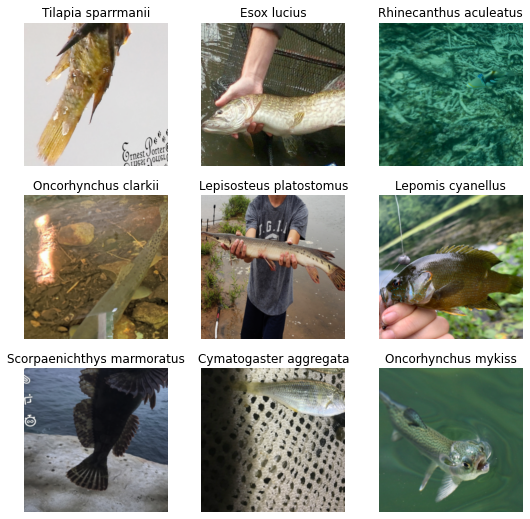

In [12]:
dls.show_batch(nrows=3, ncols=3)

In [13]:
class Resnet50CustomModel(Module):
    def __init__(self, encoder, head):
        self.encoder = encoder
        self.head = head
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.head(x)
        return x

In [14]:
def custom_splitter(model):
    return [params(model.encoder),
            params(model.head)]

In [15]:
model_meta[resnet50]

{'cut': -2,
 'split': <function fastai.vision.learner._resnet_split(m)>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}

In [16]:
model = resnet50
body = create_body(model, cut=-2)
head = create_head(2048*2,dls.c)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/user/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [17]:
model = Resnet50CustomModel(body, head)

In [18]:
weights = tensor([float(weights_df[weights_df['Specie']==c]['Weight']) for c in dls.vocab]).cuda()

In [21]:
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(weight=weights), metrics=accuracy,
                   splitter=custom_splitter).to_fp16()
learn.freeze()

In [22]:
learn.summary()

Resnet50CustomModel (Input shape: ['64 x 3 x 336 x 336'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 168 x 168  9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 168 x 168  128        True      
________________________________________________________________
ReLU                 64 x 64 x 168 x 168  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 84 x 84    0          False     
________________________________________________________________
Conv2d               64 x 64 x 84 x 84    4,096      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 84 x 84    128        True      
________________________________________________________________
Conv2d               64 x 64 x 84 x 84    36,864     False     
________________________________________

In [23]:
learn.fit(1, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.359316,2.626846,0.422865,28:06


In [24]:
learn.unfreeze()

SuggestedLRs(lr_min=1.4454397387453355e-06, lr_steep=9.999999747378752e-06)

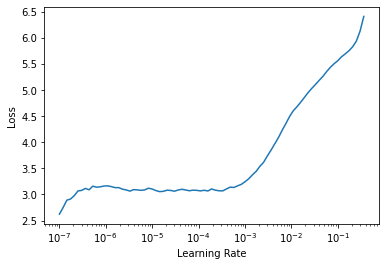

In [25]:
learn.lr_find()

In [26]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-resnet50-nobranch-fepochs1-uepochs5')

epoch,train_loss,valid_loss,accuracy,time
0,2.644957,2.084952,0.537508,29:51
1,2.517751,1.946892,0.559572,29:32
2,2.337445,1.865716,0.572339,29:25
3,2.235307,1.803286,0.584810,29:37
4,2.280476,1.747317,0.596227,29:24


Path('models/species1000-resnet50-nobranch-fepochs1-uepochs5.pth')

In [19]:
def continue_training(pth_filename):
    learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(weight=weights), metrics=accuracy,
                       splitter=custom_splitter).to_fp16()
    learn.load(pth_filename)
    learn.unfreeze()
    return learn

In [27]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-resnet50-nobranch-fepochs1-uepochs10')

epoch,train_loss,valid_loss,accuracy,time
0,2.188363,1.718827,0.601793,29:24
1,2.099192,1.671049,0.608461,29:29
2,2.046192,1.641896,0.616052,29:21
3,2.041547,1.608687,0.621323,29:24
4,2.042950,1.582894,0.625847,29:21


Path('models/species1000-resnet50-nobranch-fepochs1-uepochs10.pth')

In [20]:
learn = continue_training('species1000-resnet50-nobranch-fepochs1-uepochs10')

In [21]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-resnet50-nobranch-fepochs1-uepochs15')

epoch,train_loss,valid_loss,accuracy,time
0,2.011600,1.563754,0.632870,28:32
1,1.911954,1.537825,0.635345,29:50
2,1.901224,1.518459,0.637477,28:35
3,1.961788,1.491396,0.644251,28:43
4,1.856381,1.474682,0.647686,28:38


Path('models/species1000-resnet50-nobranch-fepochs1-uepochs15.pth')

In [22]:
learn.export('species1000-resnet50-nobranch-fepochs1-uepochs15')

# 1-Branch-CNN

In [23]:
model = resnet50
body = create_body(model, cut=-2)
body

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [24]:
stem = body[0:4]
stem

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
)

In [25]:
block1, block2, block3, block4 = body[4], body[5], body[6], body[7]
block1

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, ke

In [26]:
head = create_head(2048*2,dls.c)
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=4096, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=1000, bias=False)
)

In [27]:
def custom_get_y(o):
    fine_label = o['Specie']
    coarse1_label = o['Family']
    return [coarse1_label, fine_label]

In [28]:
class Resnet50CustomModel(Module):
    def __init__(self, encoder, head):
        self.encoder = encoder
        self.stem = encoder[0:4]
        self.block1 = body[4]
        self.block2 = body[5]
        self.branch1 = create_head(512*2, len(set(df['Family'])))
        self.block3 = body[6]
        self.block4 = body[7]
        self.head = head
    
    def forward(self, x):
        x = self.stem(x)
        x = self.block1(x)
        x = self.block2(x)
        coarse1_label = self.branch1(x)
        x = self.block3(x)
        x = self.block4(x)
        fine_label = self.head(x)
        return {
                'fine_label': fine_label,
                'coarse1_label': coarse1_label
               }

In [29]:
model = Resnet50CustomModel(body, head)

In [30]:
class CustomCategorize(DisplayedTransform):
    "Reversible transform of category string to `vocab` id"
    loss_func,order=CrossEntropyLossFlat(),1
    def __init__(self, vocab=None, vocab_coarse1=None, vocab_coarse2=None, sort=True, add_na=False, num_y=1):
        store_attr()
        self.vocab = None if vocab is None else CategoryMap(vocab, sort=sort, add_na=add_na)
        self.vocab_coarse1 = None if vocab_coarse1 is None else CategoryMap(vocab_coarse1, sort=sort, add_na=add_na)

    def setups(self, dsets):
        fine_dsets = [d[1] for d in dsets]
        coarse1_dsets = [d[0] for d in dsets]
        if self.vocab is None and dsets is not None: self.vocab = CategoryMap(fine_dsets, sort=self.sort, add_na=self.add_na)
        if self.vocab_coarse1 is None and dsets is not None: self.vocab_coarse1 = CategoryMap(coarse1_dsets, sort=self.sort, add_na=self.add_na)
        self.c = len(self.vocab)

    def encodes(self, o): return {'fine_label': TensorCategory(self.vocab.o2i[o[1]]),
                                  'coarse1_label': TensorCategory(self.vocab_coarse1.o2i[o[0]])
                                 }
    def decodes(self, o): return Category      (self.vocab    [o])

In [31]:
def CustomCategoryBlock(vocab=None, sort=True, add_na=False, num_y=1):
    "`TransformBlock` for single-label categorical targets"
    return TransformBlock(type_tfms=CustomCategorize(vocab=vocab, sort=sort, add_na=add_na))

In [32]:
def custom_splitter(model):
    return [params(model.stem),
            params(model.block1),
            params(model.block2),
            params(model.block3),
            params(model.block4),
            params(model.head)]

In [33]:
fishes = DataBlock(blocks = (ImageBlock, CustomCategoryBlock),
                 splitter=ColSplitter(),
                 get_x = ColReader(5, pref=path),
                 get_y=custom_get_y,
                 item_tfms=RandomResizedCrop(336, min_scale=0.5),
                 batch_tfms=aug_transforms())
dls = fishes.dataloaders(df)

In [34]:
dls.train_ds, dls.valid_ds

((#337741) [(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(531), 'coarse1_label': TensorCategory(25)}),(PILImage mode=RGB size=1024x738, {'fine_label': TensorCategory(776), 'coarse1_label': TensorCategory(25)}),(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(538), 'coarse1_label': TensorCategory(25)}),(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(837), 'coarse1_label': TensorCategory(41)}),(PILImage mode=RGB size=1024x786, {'fine_label': TensorCategory(32), 'coarse1_label': TensorCategory(0)}),(PILImage mode=RGB size=1024x683, {'fine_label': TensorCategory(145), 'coarse1_label': TensorCategory(109)}),(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(827), 'coarse1_label': TensorCategory(108)}),(PILImage mode=RGB size=1024x697, {'fine_label': TensorCategory(792), 'coarse1_label': TensorCategory(100)}),(PILImage mode=RGB size=1024x768, {'fine_label': TensorCategory(784), 'coarse1_label': TensorCategory(9)}),(PILImage mode=R

In [35]:
dls.vocab, dls.vocab_coarse1

((#1000) ['Abramis brama','Abudefduf abdominalis','Abudefduf bengalensis','Abudefduf saxatilis','Abudefduf septemfasciatus','Abudefduf sexfasciatus','Abudefduf sordidus','Abudefduf troschelii','Abudefduf vaigiensis','Acanthaluteres vittiger'...],
 (#135) ['Acanthuridae','Achiridae','Acipenseridae','Amiidae','Ammodytidae','Anguillidae','Antennariidae','Aphredoderidae','Aplodactylidae','Apogonidae'...])

In [36]:
weights = tensor([float(weights_df[weights_df['Specie']==c]['Weight']) for c in dls.vocab]).cuda()
weights_family = tensor([float(weights_family_df[weights_family_df['Family']==c]['Weight']) for c in dls.vocab_coarse1]).cuda()

In [37]:
def loss_func(out, targ):
    return nn.CrossEntropyLoss(weight=weights)(out['fine_label'], targ['fine_label']) + \
            nn.CrossEntropyLoss(weight=weights_family)(out['coarse1_label'], targ['coarse1_label'])

In [38]:
def custom_accuracy(inp, targ, axis=-1):
    pred1,targ1 = flatten_check(inp['fine_label'].argmax(dim=axis), targ['fine_label'])
    acc1 = (pred1 == targ1).float().mean()
    return acc1

In [39]:
learn = Learner(dls, model, loss_func=loss_func, metrics=custom_accuracy,
                   splitter=custom_splitter).to_fp16()
learn.freeze()

In [40]:
learn.summary()

Resnet50CustomModel (Input shape: ['64 x 3 x 336 x 336'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 168 x 168  9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 168 x 168  128        True      
________________________________________________________________
ReLU                 64 x 64 x 168 x 168  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 84 x 84    0          False     
________________________________________________________________
Conv2d               64 x 64 x 84 x 84    4,096      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 84 x 84    128        True      
________________________________________________________________
Conv2d               64 x 64 x 84 x 84    36,864     False     
________________________________________

In [41]:
learn.fit(1, 3e-3)
learn.save('species1000-resnet50-branch1-fepochs1-uepochs0')

epoch,train_loss,valid_loss,custom_accuracy,time
0,8.407524,7.475422,0.419217,27:57


Path('models/species1000-resnet50-branch1-fepochs1-uepochs0.pth')

In [42]:
learn.unfreeze()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=9.12010818865383e-07)

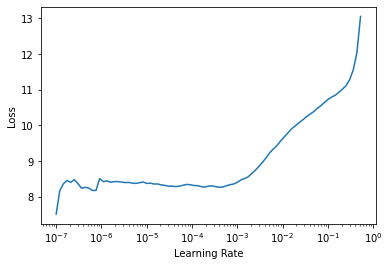

In [43]:
learn.lr_find()

In [44]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-resnet50-branch1-fepochs1-uepochs5')

epoch,train_loss,valid_loss,custom_accuracy,time
0,7.397112,6.662892,0.533576,29:59
1,7.103325,6.388296,0.576200,32:36
2,6.826472,6.192038,0.608117,29:48
3,6.624387,6.052075,0.622365,29:56
4,6.477270,5.932251,0.639573,29:56


Path('models/species1000-resnet50-branch1-fepochs1-uepochs5.pth')

In [ ]:
def continue_training(pth_filename):
    learn = Learner(dls, model, loss_func=loss_func, metrics=custom_accuracy,
                   splitter=custom_splitter).to_fp16()
    learn.load(pth_filename)
    learn.unfreeze()
    return learn

In [45]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-resnet50-branch1-fepochs1-uepochs10')

epoch,train_loss,valid_loss,custom_accuracy,time
0,6.547473,5.848159,0.654579,29:59
1,6.265859,5.778630,0.663295,29:56
2,6.213717,5.695275,0.674795,30:54
3,5.987707,5.638233,0.678028,29:55
4,6.038123,5.594209,0.682884,29:55


Path('models/species1000-resnet50-branch1-fepochs1-uepochs10.pth')

In [46]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-resnet50-branch1-fepochs1-uepochs15')

epoch,train_loss,valid_loss,custom_accuracy,time
0,5.982582,5.545159,0.689516,31:03
1,5.798176,5.491259,0.695604,30:00
2,5.762497,5.481414,0.701360,29:53
3,5.721143,5.443392,0.702615,29:56
4,5.659177,5.397123,0.706251,29:56


Path('models/species1000-resnet50-branch1-fepochs1-uepochs15.pth')

In [47]:
learn.export('species1000-resnet50-branch1-fepochs1-uepochs15')

# 2-Branch-CNN

In [11]:
model = resnet50
body = create_body(model, cut=-2)
stem = body[0:4]
block1, block2, block3, block4 = body[4], body[5], body[6], body[7]
head = create_head(2048*2,dls.c)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/user/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [12]:
def custom_get_y(o):
    fine_label = o['Specie']
    coarse2_label = o['Family']
    coarse1_label = o['Order']
    return [coarse1_label, coarse2_label, fine_label]

In [13]:
class Resnet50CustomModel(Module):
    def __init__(self, encoder, head):
        self.encoder = encoder
        self.stem = encoder[0:4]
        self.block1 = body[4]
        self.branch1 = create_head(256*2, len(set(df['Order'])))
        self.block2 = body[5]
        self.branch2 = create_head(512*2, len(set(df['Family'])))
        self.block3 = body[6]
        self.block4 = body[7]
        self.head = head
    
    def forward(self, x):
        x = self.stem(x)
        x = self.block1(x)
        coarse1_label = self.branch1(x)
        x = self.block2(x)
        coarse2_label = self.branch2(x)
        x = self.block3(x)
        x = self.block4(x)
        fine_label = self.head(x)
        return {
                'fine_label': fine_label,
                'coarse2_label': coarse2_label,
                'coarse1_label': coarse1_label
               }

In [14]:
model = Resnet50CustomModel(body, head)

In [15]:
class CustomCategorize(DisplayedTransform):
    "Reversible transform of category string to `vocab` id"
    loss_func,order=CrossEntropyLossFlat(),1
    def __init__(self, vocab=None, vocab_coarse1=None, vocab_coarse2=None, sort=True, add_na=False, num_y=1):
        store_attr()
        self.vocab = None if vocab is None else CategoryMap(vocab, sort=sort, add_na=add_na)
        self.vocab_coarse1 = None if vocab_coarse1 is None else CategoryMap(vocab_coarse1, sort=sort, add_na=add_na)
        self.vocab_coarse2 = None if vocab_coarse2 is None else CategoryMap(vocab_coarse2, sort=sort, add_na=add_na)

    def setups(self, dsets):
        fine_dsets = [d[2] for d in dsets]
        coarse2_dsets = [d[1] for d in dsets]
        coarse1_dsets = [d[0] for d in dsets]
        if self.vocab is None and dsets is not None: self.vocab = CategoryMap(fine_dsets, sort=self.sort, add_na=self.add_na)
        if self.vocab_coarse1 is None and dsets is not None: self.vocab_coarse1 = CategoryMap(coarse1_dsets, sort=self.sort, add_na=self.add_na)
        if self.vocab_coarse2 is None and dsets is not None: self.vocab_coarse2 = CategoryMap(coarse2_dsets, sort=self.sort, add_na=self.add_na)
        self.c = len(self.vocab)

    def encodes(self, o): return {'fine_label': TensorCategory(self.vocab.o2i[o[2]]),
                                  'coarse2_label': TensorCategory(self.vocab_coarse2.o2i[o[1]]),
                                  'coarse1_label': TensorCategory(self.vocab_coarse1.o2i[o[0]])
                                 }
    def decodes(self, o): return Category      (self.vocab    [o])

In [16]:
def CustomCategoryBlock(vocab=None, sort=True, add_na=False, num_y=1):
    "`TransformBlock` for single-label categorical targets"
    return TransformBlock(type_tfms=CustomCategorize(vocab=vocab, sort=sort, add_na=add_na))

In [17]:
def custom_splitter(model):
    return [params(model.stem),
            params(model.block1),
            params(model.block2),
            params(model.block3),
            params(model.block4),
            params(model.head)]

In [18]:
fishes = DataBlock(blocks = (ImageBlock, CustomCategoryBlock),
                 splitter=ColSplitter(),
                 get_x = ColReader(5, pref=path),
                 get_y=custom_get_y,
                 item_tfms=RandomResizedCrop(336, min_scale=0.5),
                 batch_tfms=aug_transforms())
dls = fishes.dataloaders(df)

In [19]:
dls.train_ds, dls.valid_ds

((#337741) [(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(531), 'coarse2_label': TensorCategory(25), 'coarse1_label': TensorCategory(20)}),(PILImage mode=RGB size=1024x738, {'fine_label': TensorCategory(776), 'coarse2_label': TensorCategory(25), 'coarse1_label': TensorCategory(20)}),(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(538), 'coarse2_label': TensorCategory(25), 'coarse1_label': TensorCategory(20)}),(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(837), 'coarse2_label': TensorCategory(41), 'coarse1_label': TensorCategory(10)}),(PILImage mode=RGB size=1024x786, {'fine_label': TensorCategory(32), 'coarse2_label': TensorCategory(0), 'coarse1_label': TensorCategory(20)}),(PILImage mode=RGB size=1024x683, {'fine_label': TensorCategory(145), 'coarse2_label': TensorCategory(109), 'coarse1_label': TensorCategory(20)}),(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(827), 'coarse2_label': TensorCategory(108), 'coarse1_la

In [20]:
dls.vocab, dls.vocab_coarse2, dls.vocab_coarse1

((#1000) ['Abramis brama','Abudefduf abdominalis','Abudefduf bengalensis','Abudefduf saxatilis','Abudefduf septemfasciatus','Abudefduf sexfasciatus','Abudefduf sordidus','Abudefduf troschelii','Abudefduf vaigiensis','Acanthaluteres vittiger'...],
 (#135) ['Acanthuridae','Achiridae','Acipenseridae','Amiidae','Ammodytidae','Anguillidae','Antennariidae','Aphredoderidae','Aplodactylidae','Apogonidae'...],
 (#29) ['Acipenseriformes','Amiiformes','Anguilliformes','Atheriniformes','Aulopiformes','Batrachoidiformes','Beloniformes','Beryciformes','Characiformes','Clupeiformes'...])

In [21]:
weights = tensor([float(weights_df[weights_df['Specie']==c]['Weight']) for c in dls.vocab]).cuda()
weights_order = tensor([float(weights_order_df[weights_order_df['Order']==c]['Weight']) for c in dls.vocab_coarse1]).cuda()
weights_family = tensor([float(weights_family_df[weights_family_df['Family']==c]['Weight']) for c in dls.vocab_coarse2]).cuda()

In [22]:
def loss_func(out, targ):
    return nn.CrossEntropyLoss(weight=weights)(out['fine_label'], targ['fine_label']) + \
            nn.CrossEntropyLoss(weight=weights_order)(out['coarse1_label'], targ['coarse1_label']) + \
            nn.CrossEntropyLoss(weight=weights_family)(out['coarse2_label'], targ['coarse2_label'])

In [23]:
def custom_accuracy(inp, targ, axis=-1):
    pred1,targ1 = flatten_check(inp['fine_label'].argmax(dim=axis), targ['fine_label'])
    acc1 = (pred1 == targ1).float().mean()
    return acc1

In [61]:
learn = Learner(dls, model, loss_func=loss_func, metrics=custom_accuracy,
                   splitter=custom_splitter).to_fp16()
learn.freeze()

In [62]:
learn.summary()

Resnet50CustomModel (Input shape: ['64 x 3 x 336 x 336'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 168 x 168  9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 168 x 168  128        True      
________________________________________________________________
ReLU                 64 x 64 x 168 x 168  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 84 x 84    0          False     
________________________________________________________________
Conv2d               64 x 64 x 84 x 84    4,096      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 84 x 84    128        True      
________________________________________________________________
Conv2d               64 x 64 x 84 x 84    36,864     False     
________________________________________

In [63]:
learn.fit(1, 3e-3)
learn.save('species1000-resnet50-branch2-fepochs1-uepochs0')

epoch,train_loss,valid_loss,custom_accuracy,time
0,11.852911,10.880882,0.377706,28:48


Path('models/species1000-resnet50-branch2-fepochs1-uepochs0.pth')

In [64]:
learn.unfreeze()

SuggestedLRs(lr_min=0.15848932266235352, lr_steep=1.3182567358016968)

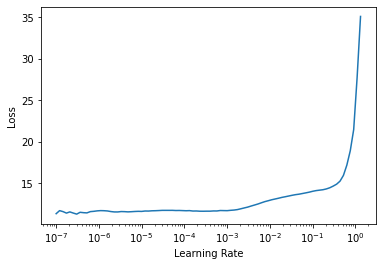

In [65]:
learn.lr_find()

In [26]:
def continue_training(pth_filename):
    learn = Learner(dls, model, loss_func=loss_func, metrics=custom_accuracy,
                   splitter=custom_splitter).to_fp16()
    learn.load(pth_filename)
    learn.unfreeze()
    return learn

In [27]:
learn = continue_training('species1000-resnet50-branch2-fepochs1-uepochs0')

In [28]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-resnet50-branch2-fepochs1-uepochs5')

epoch,train_loss,valid_loss,custom_accuracy,time
0,10.825366,9.920401,0.527038,29:44
1,10.650622,9.622943,0.565553,29:47
2,10.158860,9.410731,0.590033,29:49
3,10.060473,9.246039,0.614880,29:51
4,9.866831,9.136415,0.624580,29:47


In [30]:
learn.save('species1000-resnet50-branch2-fepochs1-uepochs5')

Path('models/species1000-resnet50-branch2-fepochs1-uepochs5.pth')

In [31]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-resnet50-branch2-fepochs1-uepochs10')

epoch,train_loss,valid_loss,custom_accuracy,time
0,9.698350,9.026076,0.643600,29:44
1,9.617804,8.939301,0.646501,29:47
2,9.386474,8.858690,0.657208,29:42
3,9.419811,8.809065,0.666765,29:42
4,9.354745,8.741025,0.667914,29:41


Path('models/species1000-resnet50-branch2-fepochs1-uepochs10.pth')

In [32]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-resnet50-branch2-fepochs1-uepochs15')

epoch,train_loss,valid_loss,custom_accuracy,time
0,9.184171,8.696441,0.669880,29:45
1,9.246830,8.676590,0.680231,29:45
2,9.030396,8.596883,0.688711,29:44
3,9.032920,8.571597,0.693176,29:45
4,8.861749,8.526108,0.699145,29:43


Path('models/species1000-resnet50-branch2-fepochs1-uepochs15.pth')

In [33]:
learn.export('species1000-resnet50-branch2-fepochs1-uepochs15')

# 2-Branch-CNN (B)

In [11]:
model = resnet50
body = create_body(model, cut=-2)
stem = body[0:4]
block1, block2, block3, block4 = body[4], body[5], body[6], body[7]
head = create_head(2048*2,dls.c)

In [12]:
def custom_get_y(o):
    fine_label = o['Specie']
    coarse2_label = o['Genus']
    coarse1_label = o['Family']
    return [coarse1_label, coarse2_label, fine_label]

In [13]:
class Resnet50CustomModel(Module):
    def __init__(self, encoder, head):
        self.encoder = encoder
        self.stem = encoder[0:4]
        self.block1 = body[4]
        self.branch1 = create_head(256*2, len(set(df['Family'])))
        self.block2 = body[5]
        self.branch2 = create_head(512*2, len(set(df['Genus'])))
        self.block3 = body[6]
        self.block4 = body[7]
        self.head = head
    
    def forward(self, x):
        x = self.stem(x)
        x = self.block1(x)
        coarse1_label = self.branch1(x)
        x = self.block2(x)
        coarse2_label = self.branch2(x)
        x = self.block3(x)
        x = self.block4(x)
        fine_label = self.head(x)
        return {
                'fine_label': fine_label,
                'coarse2_label': coarse2_label,
                'coarse1_label': coarse1_label
               }

In [14]:
model = Resnet50CustomModel(body, head)

In [15]:
class CustomCategorize(DisplayedTransform):
    "Reversible transform of category string to `vocab` id"
    loss_func,order=CrossEntropyLossFlat(),1
    def __init__(self, vocab=None, vocab_coarse1=None, vocab_coarse2=None, sort=True, add_na=False, num_y=1):
        store_attr()
        self.vocab = None if vocab is None else CategoryMap(vocab, sort=sort, add_na=add_na)
        self.vocab_coarse1 = None if vocab_coarse1 is None else CategoryMap(vocab_coarse1, sort=sort, add_na=add_na)
        self.vocab_coarse2 = None if vocab_coarse2 is None else CategoryMap(vocab_coarse2, sort=sort, add_na=add_na)

    def setups(self, dsets):
        fine_dsets = [d[2] for d in dsets]
        coarse2_dsets = [d[1] for d in dsets]
        coarse1_dsets = [d[0] for d in dsets]
        if self.vocab is None and dsets is not None: self.vocab = CategoryMap(fine_dsets, sort=self.sort, add_na=self.add_na)
        if self.vocab_coarse1 is None and dsets is not None: self.vocab_coarse1 = CategoryMap(coarse1_dsets, sort=self.sort, add_na=self.add_na)
        if self.vocab_coarse2 is None and dsets is not None: self.vocab_coarse2 = CategoryMap(coarse2_dsets, sort=self.sort, add_na=self.add_na)
        self.c = len(self.vocab)

    def encodes(self, o): return {'fine_label': TensorCategory(self.vocab.o2i[o[2]]),
                                  'coarse2_label': TensorCategory(self.vocab_coarse2.o2i[o[1]]),
                                  'coarse1_label': TensorCategory(self.vocab_coarse1.o2i[o[0]])
                                 }
    def decodes(self, o): return Category      (self.vocab    [o])

In [16]:
def CustomCategoryBlock(vocab=None, sort=True, add_na=False, num_y=1):
    "`TransformBlock` for single-label categorical targets"
    return TransformBlock(type_tfms=CustomCategorize(vocab=vocab, sort=sort, add_na=add_na))

In [17]:
def custom_splitter(model):
    return [params(model.stem),
            params(model.block1),
            params(model.block2),
            params(model.block3),
            params(model.block4),
            params(model.head)]

In [18]:
fishes = DataBlock(blocks = (ImageBlock, CustomCategoryBlock),
                 splitter=ColSplitter(),
                 get_x = ColReader(5, pref=path),
                 get_y=custom_get_y,
                 item_tfms=RandomResizedCrop(336, min_scale=0.5),
                 batch_tfms=aug_transforms())
dls = fishes.dataloaders(df)

In [19]:
dls.train_ds, dls.valid_ds

((#337741) [(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(531), 'coarse2_label': TensorCategory(231), 'coarse1_label': TensorCategory(25)}),(PILImage mode=RGB size=1024x738, {'fine_label': TensorCategory(776), 'coarse2_label': TensorCategory(341), 'coarse1_label': TensorCategory(25)}),(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(538), 'coarse2_label': TensorCategory(231), 'coarse1_label': TensorCategory(25)}),(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(837), 'coarse2_label': TensorCategory(381), 'coarse1_label': TensorCategory(41)}),(PILImage mode=RGB size=1024x786, {'fine_label': TensorCategory(32), 'coarse2_label': TensorCategory(10), 'coarse1_label': TensorCategory(0)}),(PILImage mode=RGB size=1024x683, {'fine_label': TensorCategory(145), 'coarse2_label': TensorCategory(73), 'coarse1_label': TensorCategory(109)}),(PILImage mode=RGB size=768x1024, {'fine_label': TensorCategory(827), 'coarse2_label': TensorCategory(376), 'coarse

In [20]:
dls.vocab, dls.vocab_coarse2, dls.vocab_coarse1

((#1000) ['Abramis brama','Abudefduf abdominalis','Abudefduf bengalensis','Abudefduf saxatilis','Abudefduf septemfasciatus','Abudefduf sexfasciatus','Abudefduf sordidus','Abudefduf troschelii','Abudefduf vaigiensis','Acanthaluteres vittiger'...],
 (#454) ['Abramis','Abudefduf','Acanthaluteres','Acanthistius','Acanthochromis','Acanthoclinus','Acanthocybium','Acanthogobius','Acanthopagrus','Acanthostracion'...],
 (#135) ['Acanthuridae','Achiridae','Acipenseridae','Amiidae','Ammodytidae','Anguillidae','Antennariidae','Aphredoderidae','Aplodactylidae','Apogonidae'...])

In [21]:
weights = tensor([float(weights_df[weights_df['Specie']==c]['Weight']) for c in dls.vocab]).cuda()
weights_family = tensor([float(weights_family_df[weights_family_df['Family']==c]['Weight']) for c in dls.vocab_coarse1]).cuda()
weights_genus = tensor([float(weights_genus_df[weights_genus_df['Genus']==c]['Weight']) for c in dls.vocab_coarse2]).cuda()

In [22]:
def loss_func(out, targ):
    return nn.CrossEntropyLoss(weight=weights)(out['fine_label'], targ['fine_label']) + \
            nn.CrossEntropyLoss(weight=weights_family)(out['coarse1_label'], targ['coarse1_label']) + \
            nn.CrossEntropyLoss(weight=weights_genus)(out['coarse2_label'], targ['coarse2_label'])

In [23]:
def custom_accuracy(inp, targ, axis=-1):
    pred1,targ1 = flatten_check(inp['fine_label'].argmax(dim=axis), targ['fine_label'])
    acc1 = (pred1 == targ1).float().mean()
    return acc1

In [47]:
learn = Learner(dls, model, loss_func=loss_func, metrics=custom_accuracy,
                   splitter=custom_splitter).to_fp16()
learn.freeze()

In [48]:
learn.summary()

Resnet50CustomModel (Input shape: ['64 x 3 x 336 x 336'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 168 x 168  9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 168 x 168  128        True      
________________________________________________________________
ReLU                 64 x 64 x 168 x 168  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 84 x 84    0          False     
________________________________________________________________
Conv2d               64 x 64 x 84 x 84    4,096      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 84 x 84    128        True      
________________________________________________________________
Conv2d               64 x 64 x 84 x 84    36,864     False     
________________________________________

In [49]:
learn.fit(1, 3e-3)
learn.save('species1000-resnet50-branch2b-fepochs1-uepochs0')

epoch,train_loss,valid_loss,custom_accuracy,time
0,14.803225,13.753202,0.411495,27:20


Path('models/species1000-resnet50-branch2b-fepochs1-uepochs0.pth')

In [50]:
learn.unfreeze()

SuggestedLRs(lr_min=3.0199516913853586e-06, lr_steep=6.309573450380412e-07)

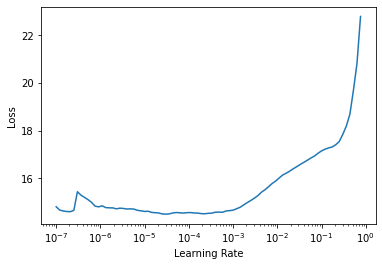

In [51]:
learn.lr_find()

In [52]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-resnet50-branch2b-fepochs1-uepochs5')

epoch,train_loss,valid_loss,custom_accuracy,time
0,13.748572,12.870766,0.543429,29:45
1,13.359264,12.581162,0.581967,29:44
2,13.138956,12.408549,0.605275,29:45
3,13.076749,12.241292,0.629483,29:47
4,12.973269,12.142198,0.637027,29:46


Path('models/species1000-resnet50-branch2b-fepochs1-uepochs5.pth')

In [24]:
def continue_training(pth_filename):
    learn = Learner(dls, model, loss_func=loss_func, metrics=custom_accuracy,
                   splitter=custom_splitter).to_fp16()
    learn.load(pth_filename)
    learn.unfreeze()
    return learn

In [53]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-resnet50-branch2b-fepochs1-uepochs10')

epoch,train_loss,valid_loss,custom_accuracy,time
0,12.805227,12.064807,0.644820,29:49
1,12.575848,11.968875,0.661389,29:49
2,12.496338,11.886747,0.670614,29:47
3,12.438288,11.836949,0.677164,29:49
4,12.379150,11.793085,0.684684,29:49


Path('models/species1000-resnet50-branch2b-fepochs1-uepochs10.pth')

In [25]:
learn = continue_training('species1000-resnet50-branch2b-fepochs1-uepochs10')

In [26]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-resnet50-branch2b-fepochs1-uepochs15')

epoch,train_loss,valid_loss,custom_accuracy,time
0,12.323430,11.741157,0.687467,30:25
1,12.287762,11.706707,0.691518,30:18
2,12.202312,11.665219,0.700744,30:17
3,12.034787,11.637124,0.706997,30:18
4,12.024626,11.598345,0.710455,30:17


Path('models/species1000-resnet50-branch2b-fepochs1-uepochs15.pth')

In [27]:
learn.export('species1000-resnet50-branch2b-fepochs1-uepochs15')

In [26]:
learn = continue_training('species1000-resnet50-branch2b-fepochs1-uepochs15')

In [27]:
learn.fit(5, slice(1e-6,1e-4))
learn.save('species1000-resnet50-branch2b-fepochs1-uepochs20')

epoch,train_loss,valid_loss,custom_accuracy,time
0,11.923400,11.572814,0.715062,30:28
1,11.920109,11.533073,0.716389,30:23
2,11.901176,11.503130,0.721162,30:27
3,11.910639,11.502769,0.720984,30:23
4,11.742609,11.476903,0.722014,30:25


Path('models/species1000-resnet50-branch2b-fepochs1-uepochs20.pth')